In [1]:
using FundamentalsNumericalComputation
FNC.init_format()

┌ Info: verify download of index files...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/MatrixDepot.jl:139
┌ Info: reading database
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:23
┌ Info: adding metadata...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:67
┌ Info: adding svd data...
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:69
┌ Info: writing database
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/download.jl:74
┌ Info: used remote sites are sparse.tamu.edu with MAT index and math.nist.gov with HTML index
└ @ MatrixDepot /Users/driscoll/.julia/packages/MatrixDepot/GEDc3/src/MatrixDepot.jl:141


(section-ivp-adaptive)=
# Adaptive Runge–Kutta

```{index} Runge–Kutta method
```

The derivation and analysis of methods for initial-value problems usually assumes a fixed step size $h$. While the error behavior $O(h^p)$ is guaranteed by {numref}`Theorem %s <theorem-euler-onestepGTE>` as $h\rightarrow 0$, this bound comes with an unknowable constant, and it is not very useful as a guide to the numerical value of the error at any particular value of $h$. Furthermore, as we saw in {numref}`section-localapprox-adaptive` for numerical integration, in many problems a fixed step size is far from the most efficient strategy.

In response we will employ the basic strategy of {numref}`section-localapprox-adaptive`: estimate the error and adapt the step size in order to reach an accuracy goal. Unlike the integration problem, though, the "integrand" of an IVP is dependent on the solution itself, so the details differ greatly.
## Step size prediction

Suppose that, starting from a given value $u_i$ and using a step size $h$, we run one step of two different RK methods simultaneously: one method with order $p$, producing $u_{i+1}$, and the other method with order $p+1$, producing $\tilde{u}_{i+1}$. In most circumstances, we can expect that $\tilde{\mathbf{u}}_{i+1}$ is a much better approximation to the solution than $\mathbf{u}_{i+1}$ is. So it seems reasonable to use 

$$E_i(h)=|\tilde{\mathbf{u}}_{i+1} - \mathbf{u}_{i+1}|$$

as an estimate of the actual local error made by the $p$th-order method. For a vector IVP, we would use a norm rather than an absolute value.

<!-- If the goal is to keep global error less than some predetermined value, we could decide to accept the new solution value if $E_i$ small enough, and otherwise reject it.[^extrap]

[^extrap]: Even though the estimate $E_i$ is meant to go with the *less* accurate proposed value $\mathbf{u}_{i+1}$, it's hard to resist the temptation to keep the more accurate value instead, and this is common in practice. -->

Now we ask: looking back, what step size *should* we have taken to meet an error target of size $\epsilon$? Let's speculate, given the behavior of local truncation error as $h\rightarrow 0$, that $E_i(h)\approx C h^{p+1}$ for an unknown constant $C$. If we had used a step size $q h$ for some $q>0$, then trivially, we would expect 

$$E_i(qh)\approx C q^{p+1}h^{p+1}.$$ 

Our best guess for $q$ would therefore be to set $E_i(qh)\approx \epsilon$, or

```{math}
  :label: adaptRKlocal
  q \approx \left(\frac{\epsilon}{E_i}\right)^{1/(p+1)}.
```

Perhaps, though, we should aim to control the contribution to *global* error, which is closer to $E_i(qh)/(q h)$. Then we end up with

```{math}
  :label: adaptRKglobal
  q \le \left(\frac{\epsilon}{E_i}\right)^{1/p}.
```

Experts have different recommendations about whether to use {eq}`adaptRKlocal` or {eq}`adaptRKglobal`. Even though {eq}`adaptRKglobal` appears to be more in keeping with our assumptions about global errors, modern practice seems to favor {eq}`adaptRKlocal`.

```{index} adaptivity; in IVP solver
```

We now have an outline of an algorithm.

(algorithm-adaptive-adapt)=
::::{proof:algorithm} Adaptive step size for an IVP
Given a solution estimate $u_i$ at $t=t_i$, and a step size $h$, do the following:
1. Produce estimates ${u}_{i+1}$ and $\tilde{u}_{i+1}$, and estimate the error.
2. If the error is small enough, adopt $\tilde{u}_{i+1}$ as the solution value at $t=t_i+h$, then increment $i$.
3. Replace $h$ by $q h$, with $q$ given by {eq}`adaptRKlocal` or {eq}`adaptRKglobal`.
4. Repeat until $t=b$.
::::

Many details remain unspecified at this point, but we first address step 1.
## Embedded formulas

Suppose, for example, we choose to use a  pair of second- and third-order RK methods to get the $\mathbf{u}_{i+1}$ and $\tilde{\mathbf{u}}_{i+1}$ needed in {numref}`Algorithm {number} <algorithm-adaptive-adapt>`. Then we seem to need at least $2+3=5$ evaluations of $f(t,y)$ for each attempted time step. This is more than double the computational work needed by the second-order method without adaptivity. 

Fortunately, the marginal cost of adaptivity can be substantially reduced by using **embedded Runge–Kutta** formulas. Embedded RK formulas are a pair of RK methods whose stages share the same internal $f$ evaluations, combining them differently in order to get estimates of two different orders of accuracy.

A good example of an embedded method is the **Bogacki–Shampine** (BS23) formula, given by the table

```{math}
:label: bs23
\begin{array}{r|cccc}
0                  & \rule{0pt}{2.75ex} &                    &                    &                    \\
\frac{1}{2}        & \frac{1}{2}        & \rule{0pt}{2.75ex} &                    &                    \\
\frac{3}{4}        & 0                  & \frac{3}{4}        & \rule{0pt}{2.75ex} &                    \\
1                 & \frac{2}{9}        & \frac{1}{3}        & \frac{4}{9}        & \rule{0pt}{2.75ex} \\[2pt] \hline
\rule{0pt}{2.75ex} & \frac{2}{9}        & \frac{1}{3}        & \frac{4}{9}        & 0                  \\[2pt] \hline
\rule{0pt}{2.75ex} & \frac{7}{24}       & \frac{1}{4}        & \frac{1}{3}        & \frac{1}{8}
\end{array}
```

The top part of the table describes four stages in the usual RK fashion. The last two rows describe how to construct a third-order estimate $\tilde{\mathbf{u}}_{i+1}$ and a second-order estimate $\mathbf{u}_{i+1}$ by taking different combinations of those stages.

## Implementation

Our implementation of an embedded second/third-order (RK23) code is given in {numref}`Function {number} <function-rk23>`. 

(function-rk23)=
````{proof:function} rk23
**Adaptive IVP solver based on embedded RK formulas**

```{code-block} julia1
:lineno-start: 1
"""
    rk23(ivp,tol)

Apply an adaptive embedded RK formula pair to solve given IVP with
estimated error `tol`. Returns a vector of times and a vector of
solution values.
"""
function rk23(ivp,tol)
    # Initialize for the first time step.
    a,b = ivp.tspan
    t = [a]
    u = [float(ivp.u0)];   i = 1;
    h = 0.5*tol^(1/3)
    s₁ = ivp.f(ivp.u0,ivp.p,a)

    # Time stepping.
    while t[i] < b
        # Detect underflow of the step size.
        if t[i]+h == t[i]
            @warn "Stepsize too small near t=$(t[i])"
            break  # quit time stepping loop
        end

        # New RK stages.
        s₂ = ivp.f( u[i]+(h/2)*s₁,   ivp.p, t[i]+h/2   )
        s₃ = ivp.f( u[i]+(3h/4)*s₂, ivp.p, t[i]+3h/4 )
        unew2 = u[i] + h*(2s₁  + 3s₂ + 4s₃)/9   # 2rd order solution
        s₄ = ivp.f( unew2, ivp.p, t[i]+h )
        err = h*(-5s₁/72 + s₂/12 + s₃/9 - s₄/8)  # 2nd/3rd difference
        E = norm(err,Inf)                         # error estimate
        maxerr = tol*(1 + norm(u[i],Inf))     # relative/absolute blend

        # Accept the proposed step?
        if E < maxerr     # yes
            push!(t,t[i]+h)
            push!(u,unew2)
            i += 1
            s₁ = s₄       # use FSAL property
        end

        # Adjust step size.
        q = 0.8*(maxerr/E)^(1/3)   # conservative optimal step factor
        q = min(q,4)               # limit stepsize growth
        h = min(q*h,b-t[i])        # don't step past the end
    end
    return t,u
end
```
````

::::{admonition} About the code
:class: dropdown
The check `t[i]+h==t[i]`on line 19 is to detect when $h$ has become so small that it no longer changes the floating-point value of $t_i$. This may be a sign that the underlying exact solution has a singularity near $t=t_i$, but in any case, the solver must halt by using a `break` statement to exit the loop.

On line 30, we use a combination of absolute and relative tolerances to judge the acceptability of a solution value, as in {eq}`absreltolerance`. In lines 41--43 we underestimate the step factor $q$ a bit and prevent a huge increase in the step size, since a rejected step is expensive, and then we make sure that our final step doesn't take us past the end of the domain.

Finally, line 37 exploits a subtle property of the BS23 formula called *first same as last* (FSAL). 
While {eq}`bs23` calls for four stages to find the paired second- and third-order estimates, the final stage computed in stepping from $t_i$ to $t_{i+1}$ is identical to the first stage needed to step from $t_{i+1}$ to $t_{i+2}$. By repurposing `s₄` as `s₁` for the next pass, one of the stage evaluations comes for free, and only three evaluations of $f$ are needed per successful step.
::::

(demo-adapt-basic)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

Let's run adaptive RK on  $u'=e^{t-u\sin u}$.

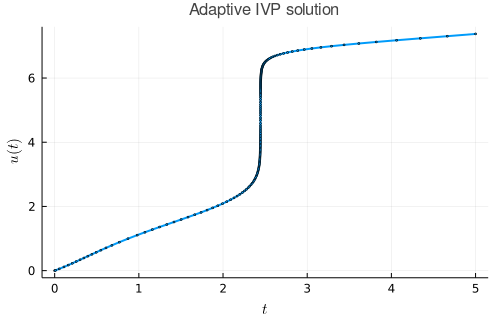

In [2]:
f = (u,p,t) -> exp(t-u*sin(u))
ivp = ODEProblem(f,0,(0.,5.))
t,u = FNC.rk23(ivp,1e-5)

plot(t,u,m=2,
    xlabel=L"t",ylabel=L"u(t)",title="Adaptive IVP solution")

The solution makes a very abrupt change near $t=2.4$. The resulting time steps vary over three orders of magnitude.

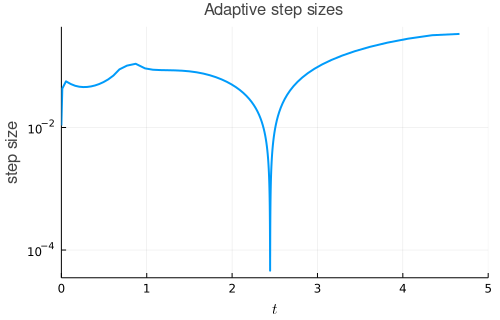

In [3]:
Δt = diff(t)
plot(t[1:end-1],Δt,title="Adaptive step sizes",
    xaxis=(L"t",(0,5)),yaxis=(:log10,"step size"))

If we had to run with a uniform step size to get this accuracy, it would be

In [4]:
println( "minimum step size = $(minimum(Δt))" )

minimum step size = 4.6096854609878335e-5


On the other hand, the average step size that was actually taken was

In [5]:
println( "average step size = $(sum(Δt)/(length(t)-1))" )

average step size = 0.03205128205128205


We took fewer steps by a factor of almost 1000! Even accounting for the extra stage per step and the occasional rejected step, the savings are clear.
```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```

(demo-adapt-sing)=
```{proof:demo}
```

```{raw} html
<div class='demo'>
```

```{raw} latex
%%start demo%%
```

In {numref}`Demo %s <demo-basics-sing>` we saw an IVP that appears to blow up in a finite amount of time. Because the solution increases so rapidly as it approaches the blowup, adaptive stepping is required even to get close.

In [6]:
f = (u,p,t) -> (t+u)^2
ivp = ODEProblem(f,1,(0.,1.))
t,u = FNC.rk23(ivp,1e-5);

┌ Warning: Stepsize too small near t=0.7854087204072808
└ @ FundamentalsNumericalComputation /Users/driscoll/.julia/dev/FundamentalsNumericalComputation/src/chapter06.jl:93


In fact, the failure of the adaptivity gives a decent idea of when the singularity occurs.

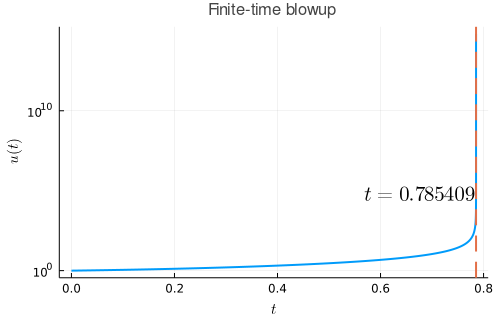

In [7]:
plot(t,u,legend=:none,
    xlabel=L"t",yaxis=(:log10,L"u(t)"),title="Finite-time blowup")

tf = t[end]
vline!([tf],l=:dash)
annotate!(tf,1e5,latexstring(@sprintf("t = %.6f ",tf)),:right)

```{raw} html
</div>
```

```{raw} latex
%%end demo%%
```

```{index} stiff differential equation
```

Often the adaptively chosen steps clearly correspond to identifiable features of the solution. However, there are so-called *stiff problems* in which the time steps seem unreasonably small in relation to the observable behavior of the solution. These problems benefit from a particular type of solver that is considered in {numref}`section-ivp-implicit`.

## Exercises

1. ⌨ Using {numref}`Function {number} <function-rk23>` with an error tolerance of $10^{-8}$, solve $y'' +(1+y')^3 y = 0$ over $ 0 \le t \le 4 \pi$ with the indicated initial conditions. Plot $y(t)$ and $y'(t)$ as functions of $t$ and separately plot the time step size as a function of $t$.

    **(a)** $y(0) = 0.1, \quad y'(0) = 0$

    **(b)** $y(0) = 0.5, \quad y'(0) = 0$

    **(c)** $y(0) = 0.75, \quad y'(0) = 0$

    **(d)** $y(0) = 0.95, \quad y'(0) = 0$

2. ⌨ Solve the FitzHugh–Nagumo system from [Exercise 4.3.6](problem-systems-fitznag) for $I=0.05740$ using {numref}`Function {number} <function-rk23>` with error tolerance $10^{-2}$, $10^{-3}$, and $10^{-4}$. (This illustrates that the error tolerance is a target, not a guarantee!)

3. ✍ Derive Equation {eq}`adaptRKglobal` using the stated assumption about controlling global rather than local error.

4. ⌨ Solve the problem $u'=100u^2-u^3$, $u(0)=0.0002$, $0\le t \le 100$, and make plots that show both the solution and the time steps taken. The solution makes a quick transition between two nearly constant states. Does the step size selection behave the same in both states?